<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/03_Conv_LSTM_univariate_car_sales_14_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# evaluate convlstm for monthly and weekly sales dataset


In [1]:
#Import Libraries
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_excel
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot


In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values


In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))


In [5]:
# difference dataset
def difference(data, interval):
  return [data[i] - data[i - interval] for i in range(interval, len(data))]


In [6]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
  n_input = n_seq * n_steps
  # prepare data
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
  # define model
  model = Sequential()
  model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu',
  input_shape=(n_seq, 1, n_steps, 1)))
  model.add(Flatten())
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [7]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_seq, n_steps, _, _, _, _, _ = config
  n_input = n_seq * n_steps
  # prepare data
  x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]


In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

In [9]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  return scores


In [10]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
  # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()


Load quarterly and monthly datasets

 > 332553.660
 > 296133.758
 > 266876.179
 > 333175.638
 > 259930.662
 > 285596.133
 > 284922.945
 > 294566.621
 > 301251.210
 > 331370.914
 > 244362.718
 > 308839.608
 > 347152.070
 > 282349.018
 > 333872.968
 > 328184.457
 > 304859.735
 > 313476.729
 > 320670.391
 > 265741.619
 > 299789.923
 > 295794.759
 > 331418.873
 > 308685.306
 > 317261.808
 > 301226.138
 > 305825.764
 > 311276.480
 > 320941.421
 > 303351.407
convlstm: 304381.964 RMSE (+/- 23943.734)


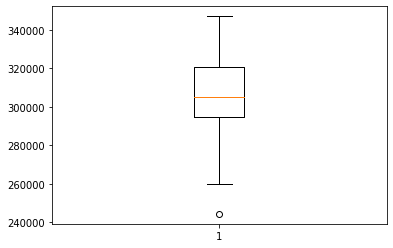

In [11]:
series = read_excel('/content/Sales-quarterly.xlsx', header=0, index_col=0)
series = DataFrame(series['Sales'])
data = series.values
# data split
n_test = 4
# define config
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.
config = [1, 4, 64, 1, 16, 20, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)


 > 112511.471
 > 154898.253
 > 157885.213
 > 155453.056
 > 121816.649
 > 126424.393
 > 146886.831
 > 159796.386
 > 146879.843
 > 150471.609
 > 127883.805
 > 129680.211
 > 131458.633
 > 136505.584
 > 135680.318
 > 138304.140
 > 107887.945
 > 139544.832
 > 148391.275
 > 122283.049
 > 139479.637
 > 143487.455
 > 134579.768
 > 146858.904
 > 135125.372
 > 129995.513
 > 144522.407
 > 145805.218
 > 129011.159
 > 133237.803
convlstm: 137758.224 RMSE (+/- 12524.338)


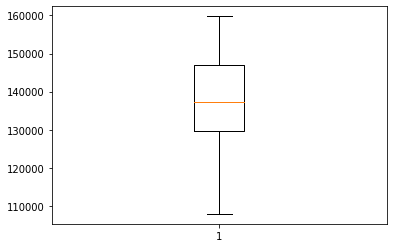

In [12]:
series = read_excel('/content/Sales-monthly.xlsx', header=0, index_col=0)
series = DataFrame(series['Sales'])
data = series.values
# data split
n_test = 12
# define config
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.
config = [3, 4, 64, 3, 16, 20, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)
